Setup

In [1]:
#import required libs

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
#Class that will generate user functions

'''
1. user is assigned set of random context value (location,device,age)
2. user's probability of clicking on ad (y) is depende on context and they see ad[C,T]
3. CTR is modeled as logistic function of context (diff parameters for C and T)
'''

class UserGenerator(object):
    def __init__(self):
        self.beta= {}
        self.beta['C'] = np.array([-6,-0.1,1,0.1])
        self.beta['T'] = np.array([-3.5,-0.1,-3,0.1])
        self.context = None
        
    def logistic(self,beta,context):
        f = np.dot(beta,context)
        p = 1 / (1 + np.exp(-f))
        return p
    
    def display_ad(self,ad):
        if ad in ['C','T']:
            p = self.logistic(self.beta[ad],self.context)
            reward = np.random.binomial(n=1,p=p)
            return reward
        else:
            raise Exeception("Unknown Ad! ")
            
    def generate_user_with_context(self):
        location = np.random.binomial(n=1,p=0.6)
        device = np.random.binomial(n=1,p=0.8)
        age = 10 + int(np.random.beta(2,3) * 60)
        self.context = [1,device,location,age]
        return self.context
    

In [3]:
#define random policy for A/B testing
#ad [C,T] selected randomly with probabilities p

def ab_policy(arms,slate_size=1,p=[0.6,0.4]):
    recs = np.random.choice(arms,size=(slate_size),replace=False,p=p)
    return recs

In [31]:
#define e-greedy policy for MAB
def mab_policy(df,arms,epsilon=0.15,slate_size=1):
    explore = np.random.binomial(1,epsilon)
    
    if explore == 1 or df.shape[0] == 0:
        recs = np.random.choice(arms,size=(slate_size),replace=False)
    else:
        scores = df[['d','y']].groupby('d').agg({'y' : ['mean','count']})
        scores.columns = ['mean','count']
        scores['d'] = scores.index
        scores = scores.sort_values('mean',ascending=False)
        recs = scores.loc[scores.index[0:slate_size],'d'].values
    return recs
        

Contextual Bandit 

In [37]:
class RegularizedLR(object):
    def __init__(self,name,alpha,rlambda,n_dim):
        self.name = name
        self.alpha = alpha
        self.rlambda = rlambda
        self.n_dim = n_dim
        self.m = np.zeros(n_dim)
        self.q = np.ones(n_dim) * rlambda
        self.w = self.get_sampled_weights()
        
    def get_sampled_weights(self):
        w = np.random.normal(self.m,self.alpha*self.q**(-1/2))
        return w
    
    def loss(self,w,*args):
        X,y = args
        n = len(y)
        regularizer = 0.5 * np.dot(self.q,(w-self.m)**2)
        pred_loss = sum([np.log(1 + np.exp(np.dot(w,X[j]))) - y[j] * np.dot(w,X[j]) for j in range(n)])
        
        return regularizer + pred_loss
    
    def fit(self,X,y):
        if y:
            X = np.array(X)
            y = np.array(y)
            
            minimization = minimize(self.loss,self.w,args=(X,y),method="L-BFGS-B",bounds=[(-10,10)]*3 + [(-1,1)],
                                   options = {'maxiter' : 50})
            
            self.w = minimization.x
            self.m = self.w
            p = (1 + np.exp(-np.matmul(self.w,X.T)))**(-1)
            self.q = self.q + np.matmul(p * (1-p), X**2)
            
    def calc_sigmoid(self,w,context):
        return 1/(1+np.exp(-np.dot(w,context)))
    def get_prediction(self,context):
        return self.calc_sigmoid(self.m,context)
    
    def sample_prediction(self,context):
        w = self.get_sampled_weights()
        return self.calc_sigmoid(w,context)
    
    def get_ucb(self,context):
        pred = self.calc_sigmoid(self.m,context)
        confidence = self.alpha * np.sqrt(np.sum(np.divide(np.array(context)**2,self.q)))
        ucb = pred + confidence
        return ucb
        

In [44]:
def cb_policy_egreedy(ad_models,context,eps):
    if np.random.uniform() < eps:
        return np.random.choice(list(ad_models.keys()))
    
    else:
        predictions = {ad: ad_models[ad].get_prediction(context) for ad in ad_models}
        max_value = max(predictions.values())
        max_keys = [key for key,value in predictions.items() if value == max_value]
        return np.random.choice(max_keys)

In [4]:
def score(history,df,t,batch_size,recs):
    actions = df[t:t+batch_size]
    actions = actions.loc[actions['d'].isin(recs)]
    actions['scoring_round'] = t
    history = pd.concat([history,pd.DataFrame(actions)])
    action_liked = actions[['d','y']]
    return history, action_liked

Simulate logged data

In [5]:
#simulate 100k users that receive ad T with probability 0.75

num_samples = 100000
prob_treated = 0.75

In [8]:
# initialize the dataframe

df = pd.DataFrame(np.nan,index=range(0,num_samples),columns = ['d','y','bias_term','location','device','age'])
#here index is user_id, d is arm aka action taken "which item was recommended or chosen" and y is "CTR aka click (1) or no click(0)" 

print(df.shape)
df.head()

(100000, 6)


,d,y,bias_term,location,device,age
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#generate the users

ug = UserGenerator()

for i in range(0,num_samples):
    context = ug.generate_user_with_context()
    d = np.random.binomial(1,prob_treated)
    if d == 0:
        y = ug.display_ad('C')
    else:
        y = ug.display_ad('T')
    df.loc[i] = [d,y] + context
    
df['t'] = range(0,df.shape[0])
print(df.shape)
df.head()

(100000, 7)


,d,y,bias_term,location,device,age,t
0,0.0,0.0,1.0,1.0,0.0,12.0,0
1,1.0,0.0,1.0,1.0,1.0,24.0,1
2,0.0,0.0,1.0,0.0,0.0,26.0,2
3,0.0,1.0,1.0,1.0,1.0,53.0,3
4,0.0,0.0,1.0,1.0,0.0,30.0,4


In [14]:
#calculate fraction of users that receives T (should be approx 75%)
#and average y values by C and T (T should be higher by 6%)

print(df.d.mean())
print(df.groupby('d').mean()['y'])

0.75327
d
0.0    0.162769
1.0    0.219735
Name: y, dtype: float64


In [16]:
#upsample C and downsample T to balance dataset with 50/50 % of C and T ad.

df0 = df[df.d==0].sample(50000,replace=True)
df1 = df[df.d==1].sample(50000,replace=True)

df = pd.concat([df0,df1],ignore_index=True)

df.drop(columns=['t'])

df = df.sample(frac=1).reset_index(drop=True)
df['t'] = range(0,df.shape[0])

print(df.shape)
df.head()

(100000, 7)


,d,y,bias_term,location,device,age,t
0,1.0,1.0,1.0,1.0,0.0,20.0,0
1,0.0,0.0,1.0,0.0,1.0,32.0,1
2,0.0,0.0,1.0,0.0,1.0,12.0,2
3,0.0,0.0,1.0,1.0,1.0,37.0,3
4,1.0,0.0,1.0,1.0,1.0,18.0,4


In [18]:
print(df.d.mean())
print()
print(df.groupby('d').mean()['y'])

0.5

d
0.0    0.16764
1.0    0.22056
Name: y, dtype: float64


Calculate Cumulative Reward for A/B Testing

In [21]:
history = pd.DataFrame(data=None,columns=df.columns)

rewards = []
max_time = df.shape[0]
batch_size=100
n=1

for t in range(max_time//batch_size):
    t = t * batch_size
    recs = ab_policy(arms=df.d.unique(),slate_size=n,p=[0.6,0.4])
    history, action_score = score(history,df,t,batch_size,recs)
    if action_score is not None:
        action_score = action_score.y.tolist()
        rewards.extend(action_score)

rewards_ab = rewards
history_ab = history
print(len(rewards_ab))
rewards_ab[:10]

49830


[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [22]:
cumulative_ab = np.cumsum(rewards_ab)

print(len(cumulative_ab))
cumulative_ab[:10]

49830


array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])

Calculate Cumulative reward for MAB

In [32]:
history = pd.DataFrame(data=None,columns=df.columns)

rewards = []
max_time = df.shape[0]
batch_size=100
epsilon = 0.15
n = 1

for t in range(max_time//batch_size):
    t=t*batch_size
    recs = mab_policy(df = history.loc[history.t<=t,],arms = df.d.unique(),epsilon=epsilon,slate_size=n)
    history,action_score  = score(history,df,t,batch_size,recs)
    if action_score is not None:
        action_score = action_score.y.tolist()
        rewards.extend(action_score)

rewards_mab = rewards
history_mab = history

print(len(rewards_mab))
rewards_mab[0:10]

50100


[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [33]:
cumulative_mab = np.cumsum(rewards_mab)

print(len(cumulative_mab))
cumulative_mab[:10]

50100


array([1., 1., 1., 1., 2., 2., 2., 2., 2., 2.])

Calculate Cumulative reward for Contextual Bandit

In [46]:
history = pd.DataFrame(data=None,columns=df.columns)

rewards = []
max_time = df.shape[0]
batch_size = 10000
eps = 0.15

ad_options = ['C','T']
alpha, rlambda,n_dim = 0.5,0.5,4
ad_models = {ad: RegularizedLR(ad,alpha,rlambda,n_dim) for ad in 'CT'}

X = {ad: [] for ad in ad_options}
y = {ad: [] for ad in ad_options}

for t in range(max_time):
    context = list(df.iloc[t][['bias_term','location','device','age']])
    
    ad = cb_policy_egreedy(ad_models,context,eps)
    
    if (ad == 'C' and df.iloc[t]['d'] == 0) or (ad == 'T' and df.iloc[t]['d'] == 1):
        click = df.iloc[t]['y']
        actions = df[t:t+1]
        actions['scoring_round'] = t
        history = pd.concat([history,pd.DataFrame(actions)])
        action_score = actions[['d','y']]
        action_score = action_score.y.tolist()
        rewards.extend(action_score)
        
        X[ad].append(context)
        y[ad].append(click)
        
    if (t+1) % batch_size == 0:
        print("Updating the models at t: ", t+1)
        for ad in ad_options:
            ad_models[ad].fit(X[ad],y[ad])
        
        X = {ad :[] for ad in ad_options}
        y = {ad :[] for ad in ad_options}
        
rewards_cb = rewards
history_cb = history

print()
print(len(rewards_cb))
rewards_cb[:10]


Updating the models at t:  10000
Updating the models at t:  20000
Updating the models at t:  30000
Updating the models at t:  40000
Updating the models at t:  50000
Updating the models at t:  60000
Updating the models at t:  70000
Updating the models at t:  80000
Updating the models at t:  90000
Updating the models at t:  100000

49971


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [47]:
cumulative_cb = np.cumsum(rewards_cb)

print(len(cumulative_cb))

cumulative_cb[:10]

49971


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

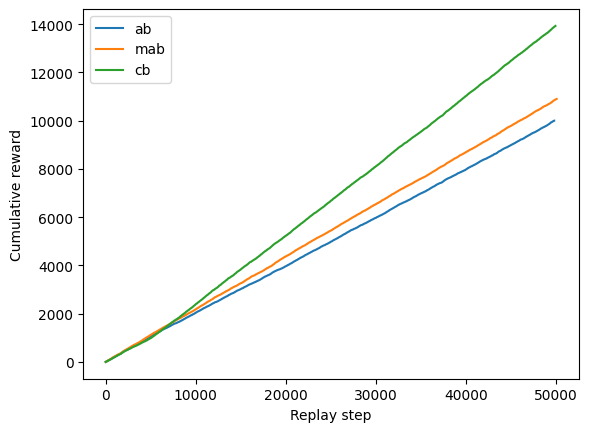

In [48]:
plt.plot(cumulative_ab, label='ab')
plt.plot(cumulative_mab, label='mab')
plt.plot(cumulative_cb, label='cb')

plt.xlabel("Replay step")
plt.ylabel("Cumulative reward")

plt.legend()

plt.savefig('ab_vs_mab_vs_cb.png')

In [49]:
print(cumulative_cb[-1] - cumulative_mab[-1])
print(cumulative_cb[-1] - cumulative_ab[-1])
print(cumulative_mab[-1] - cumulative_ab[-1])

3024.0
3925.0
901.0


Reference
Many parts of the code in this notebook are copied from the following scripts and modified as needed to adapt to the example being demonstrated here:

https://github.com/PacktPublishing/Mastering-Reinforcement-Learning-with-Python/blob/master/Chapter03/Contextual%20Bandits.ipynb
https://github.com/jldbc/bandits/tree/master/bandits
The repositories where these code snippets originally appeared in have the following LICENSE notices.

MIT License

Copyright (c) 2020 Packt

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

MIT License

Copyright (c) 2019 James LeDoux

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.